# A RNN generating music

## Preparation

In [1]:
import tensorflow as tf 
print("tf version: "+tf.__version__)
import numpy as np
import os
import regex
import time
import functools
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
!apt-get install abcmidi timidity

tf version: 2.2.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  freepats libaudio2 timidity-daemon
Suggested packages:
  abcm2ps postscript-viewer nas fluid-soundfont-gm fluid-soundfont-gs pmidi
The following NEW packages will be installed:
  abcmidi freepats libaudio2 timidity timidity-daemon
0 upgraded, 5 newly installed, 0 to remove and 33 not upgraded.
Need to get 29.9 MB of archives.
After this operation, 36.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 abcmidi amd64 20180222-1 [280 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 freepats all 20060219-1 [29.0 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaudio2 amd64 1.9.4-6 [50.3 kB]
Get:4 http://archi

Mount your Google drive folder to /content/drive/My Drive/

In [14]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Go the project directory on your Google drive (create one if necessary)

In [15]:
cd /content/drive/My Drive/musico_nn/

/content/drive/My Drive/musico_nn


In [16]:
pwd

'/content/drive/My Drive/musico_nn'

Set the data directory on your Google drive (create one if necessary)

In [17]:
data_dir = '/content/drive/My Drive/data/'

Download [data](https://drive.google.com/file/d/1i7AJrnx3sKthcpZK7ikVChImE9AGP_AT/view?usp=sharing), and upload it to `data_dir`.

## Load dataset  

In [9]:
text = open(data_dir+'classical_songs.abc').read()
print(text[:500])



X: 1
T: Elverton Grove
M:4/4
L:1/8
Z:Alf Warnock - alf.warnock@rogers.com
K:A
E2|"A"A2f2 e2d2|"A"c4 "E"B3A/2B/2|"A"c2E2 "E"B2E2|"A"c2E2 "E"B2E2|
"A"A2f2 e2d2|c4 "E"B3c|"D"d2cB "E"c2BA|"A"A6:|
d2|"F#m"c2B2 "C#"A2G2|"F#m"F4 f4| c2B2 "C#"A2G2|"F#m"F^EFG F2d2|
c2B2 "C#"A2G2|"F#m"F4 "D"f4| "F#m"c2B2 "C#"A2G2|"F#m"F6fg|
"F#m"a2gf "E"g2fe|"D"f2ed "A"e2dc|"Bm"d2cB "A"c2BA|
"E"BAGF E2e2|"A"e6e2|"E"e6fg|
"F#m"a2gf "E"g2fe|"D"f2ed "A"e2dc|"D"d2cB "A"c2BA|
"E"BAGF E2e2|"D"f2A2 "A"e2A2|"E"d4 "F#m"c4|
"D"FG


In [10]:
# The unique characters in the dataset
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

97 unique characters


In [53]:
# Convert songs contained in a string like text to .wav files
class Waver:

  def __init__(self, abc_text):

    self.abc_text = abc_text
    self.songs = ''

  def extract_song_snippet(self):
    pattern = '\n\n(.*?)\n\n'
    search_results = regex.findall(pattern, self.abc_text, overlapped=True, flags=regex.DOTALL)
    self.songs = [song for song in search_results]
    print ("Found {} possible songs in generated texts".format(len(self.songs)))

  def save_song_to_abc(self, song, basename="tmp"):
    full_name = "{}.abc".format(basename)
    with open(full_name, "w") as f:
        f.write(song)
  
  def abc_to_wav(self, basename):
    os.system('abc2midi "{}.abc" -o "{}.mid"'.format(basename, basename))
    os.system('timidity "{}.mid" -Ow "{}.wav"'.format(basename, basename))
    os.system('rm "{}.abc" "{}.mid"'.format(basename, basename))
  
  def save_songs(self, dir, num_of_songs):
    if not os.path.isdir(dir):
      os.mkdir(dir)

    self.extract_song_snippet()

    if len(self.songs) == 0:
        print ("No valid songs found in text.")

    i=0
    for song in self.songs:
        if 'T:' in song:
            pattern = 'T:([\w \']*)\n'
            match = regex.search(pattern, song)
            if match:
              basename=match.group(1).strip()
              basename=os.path.join(dir, basename)
              self.save_song_to_abc(song, basename)
              self.abc_to_wav(basename)
              print('Trying to save "{}.wav".'.format(basename))
            else:
              print("Title of the song is not valid.")    
        # only save first 10 songs
        i=i+1
        if i==num_of_songs: break

In [18]:
Waver(text).save_songs('original_music/',5)

Found 796 possible songs in generated texts
Trying to save "original_music/ Elverton Grove.wav".
Title of the song is not valid.
Trying to save "original_music/ Woodlark.wav".
Trying to save "original_music/Belfast Hornpipe 2.wav".
Trying to save "original_music/Belfast Hornpipe 2.wav".


In [19]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
# Convert text to a vector
text_as_int = np.array([char2idx[c] for c in text])

# Create a mapping from indices to characters
idx2char = np.array(vocab)

# Data is vectorized
print ('{} ---- characters mapped to ints ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'\n\nX: 1\nT: Elv' ---- characters mapped to ints ---- > [ 0  0 57 27  1 18  0 53 27  1 38 76 86]


In [32]:
# Create input data and target data
# Break the text into sequences of seq_length+1, each sequence is one data point(example).
# Suppose seq_length is 4, for sequence "Hello" in the text, our input sequence is "Hell", and the target sequence "ello".

seq_length = 100 # dimension of data point
# of data points in a epoch (whole dataset).
num_data_points = len(text)//(seq_length+1) 

dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
# Use the batch function to generate sequences of 101
sequences = dataset.batch(seq_length+1, drop_remainder=True)

# Define the input part and target part of each sequence of 101 
def split_input_target(sequence):
    input_part = sequence[:-1]
    target_part = sequence[1:]
    return input_part, target_part

# Use the map method to apply your function to the list of sequences.
dataset = sequences.map(split_input_target)

In [33]:
# shape of each data point
for element in dataset:
  print(element)
  break

(<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([ 0,  0, 57, 27,  1, 18,  0, 53, 27,  1, 38, 76, 86, 69, 82, 84, 79,
       78,  1, 40, 82, 79, 86, 69,  0, 46, 27, 21, 16, 21,  0, 45, 27, 18,
       16, 25,  0, 59, 27, 34, 76, 70,  1, 56, 65, 82, 78, 79, 67, 75,  1,
       14,  1, 65, 76, 70, 15, 87, 65, 82, 78, 79, 67, 75, 33, 82, 79, 71,
       69, 82, 83, 15, 67, 79, 77,  0, 44, 27, 34,  0, 38, 19, 92,  3, 34,
        3, 34, 19, 70, 19,  1, 69, 19, 68, 19, 92,  3, 34,  3, 67])>, <tf.Tensor: shape=(100,), dtype=int64, numpy=
array([ 0, 57, 27,  1, 18,  0, 53, 27,  1, 38, 76, 86, 69, 82, 84, 79, 78,
        1, 40, 82, 79, 86, 69,  0, 46, 27, 21, 16, 21,  0, 45, 27, 18, 16,
       25,  0, 59, 27, 34, 76, 70,  1, 56, 65, 82, 78, 79, 67, 75,  1, 14,
        1, 65, 76, 70, 15, 87, 65, 82, 78, 79, 67, 75, 33, 82, 79, 71, 69,
       82, 83, 15, 67, 79, 77,  0, 44, 27, 34,  0, 38, 19, 92,  3, 34,  3,
       34, 19, 70, 19,  1, 69, 19, 68, 19, 92,  3, 34,  3, 67, 21])>)


In [34]:
# Create training batches

# Make 64 data points as a batch, one batch is one step per epoch, # of steps is just # of batches
BATCH_SIZE = 64
steps_per_epoch = num_data_points//BATCH_SIZE

# Shuffle for the purpose of stochastic gradient descent
dataset = dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)

In [35]:
# shape of each data point
for element in dataset:
  print(element)
  break

(<tf.Tensor: shape=(64, 100), dtype=int64, numpy=
array([[68, 67, 34, ..., 82, 83, 15],
       [27,  1, 37, ..., 92,  0,  3],
       [76, 84, 90, ...,  3, 39, 19],
       ...,
       [92, 70, 69, ..., 79, 77, 13],
       [ 3, 38, 21, ..., 19, 92,  3],
       [92, 39, 38, ..., 68,  1, 66]])>, <tf.Tensor: shape=(64, 100), dtype=int64, numpy=
array([[67, 34,  1, ..., 83, 15, 67],
       [ 1, 37, 65, ...,  0,  3, 34],
       [84, 90,  0, ..., 39, 19,  1],
       ...,
       [70, 69, 68, ..., 77, 13,  1],
       [38, 21,  1, ..., 92,  3, 34],
       [39, 38, 37, ...,  1, 66, 89]])>)


## Define Model

In [36]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors of a size `embedding_dim`
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    LSTM(rnn_units), 

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output into the vocabulary size. 
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

# Build a simple model with default hyperparameters.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=BATCH_SIZE)

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           24832     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 97)            99425     
Total params: 5,371,233
Trainable params: 5,371,233
Non-trainable params: 0
_________________________________________________________________


In [38]:
# We can also quickly check the dimensionality of our output, using a dataset defined with a sequence length of 100. None -> 100
# Note that the model can be run on inputs of any length

for input_batch, target_batch in dataset: 
  # Predictions from the untrained model
  prediction_batch = model(input_batch)
  print('logits of a batch:\n',prediction_batch)
  break

logits of a batch:
 tf.Tensor(
[[[-3.2675005e-03 -4.0737516e-04  4.3941243e-04 ... -4.8282603e-03
    5.9235911e-03  7.1485285e-03]
  [ 1.2522783e-03 -3.1620034e-03 -2.1436960e-03 ... -8.1411730e-03
    5.4648854e-03  2.2199531e-03]
  [-4.2045787e-03 -2.9066196e-03 -1.5011302e-03 ... -1.4345022e-03
    6.5563773e-03 -2.0104302e-03]
  ...
  [ 5.7100982e-04 -1.1947012e-02  6.2766648e-03 ... -4.4960063e-04
    3.7017786e-03 -7.3161200e-03]
  [-1.0301850e-03 -9.3148407e-03  9.1192182e-03 ... -3.6876458e-03
    3.4176689e-03 -7.9163369e-03]
  [ 4.3227780e-04 -1.2575446e-02  1.0634663e-02 ... -2.8602434e-03
    2.8516897e-03 -3.3184935e-03]]

 [[ 3.5452868e-03 -8.2518847e-04 -4.1995505e-03 ...  3.3501985e-03
    5.1250788e-03  9.8371948e-04]
  [ 5.5319266e-03 -4.4618733e-03 -4.8728432e-03 ... -2.5036104e-03
    3.5259093e-03 -4.3596197e-03]
  [-1.5869763e-03 -4.3813325e-03 -2.8471656e-03 ...  2.2176772e-03
    4.1696941e-03 -8.2365815e-03]
  ...
  [ 3.7666801e-03  5.7736202e-03 -4.9487464e-0

In [39]:
# We are using a categorical distribution to sample over the prediction_batch
sampled_indices = tf.random.categorical(prediction_batch[0], num_samples=1) # multinomial distribution
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
print(sampled_indices)

[27 23 57 95 70 52  0 27 16 53 68 30 42 60 15 91 11 19 51 19 64 12 29 47
  8 90 56 72 50 63 78 12  3 93 96 38 13 95 46  4 81 91 88 54  2 32 45 26
 28 72 20  8 67 47 11  4 58 96 75 79 29 76 15 76 12 25 56 73 25 74 60 36
 85 83  9 43 84 46  4 20 21 69 41 26 82 36 13 83 75 73 61 67 72 29 10 77
 40  1 71 66]


In [40]:
# We can now decode these to see the text predicted by the untrained model
print("Input: \n", repr("".join(idx2char[input_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'e fefg|[1 aaga faec|dfec A2ed:|[2 afge faec|dfec A2zA|\n|:EAcA EAcA|GABc dBBA|GBEB GBEB|GBEB A3A|\nEAc'

Next Char Predictions: 
 ':6X抯fS\n:/Td=I[.{*2R2_+<N\'zWhQ^n+"}閍E,抯M#q{xU!?L9;h3\'cN*#Y閍ko<l.l+8Wi8j[Cus(JtM#34eH9rC,ski\\ch<)mG gb'


## Train

In [41]:
# We can think of our next character prediction problem as a standard classification problem.
# At a given time step, we have the previous state of the RNN as well as the input, 
# and want to predict the class of the next character. We will use the sparse_categorical_crossentropy loss,
# as it comparing integer targets to logits for categorical classification tasks.

def compute_loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# Compute the loss using the example batch and predictions from the untrained model
batch_loss  = compute_loss(target_batch, prediction_batch)
print("target_batch shape: ", target_batch.shape)
print("prediction_batch shape: ", prediction_batch.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", batch_loss.numpy().mean())

target_batch shape:  (64, 100)
prediction_batch shape:  (64, 100, 97)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.57511


epoch:0|=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>|loss:0.14415064454078674
epoch:1|=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>|loss:0.12963031232357025
epoch:2|=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>|loss:0.14069020748138428
epoch:3|=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>|loss:0.13027028739452362
epoch:4|=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>|loss:0.13476251065731049
epoch:5|=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>|loss:0.13063156604766846
epoch:6|=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>|loss:0.13654670119285583
epoch:7|=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>|loss:0.1377723664045334
epoch:8|=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=

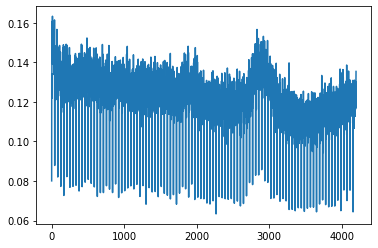

In [46]:
# Training the model, you can run this mutiple times to reduce loss, i.e. set EPOCHS ver large 
EPOCHS = 100
optimizer = tf.optimizers.Adam()
checkpoint_name = os.path.join('ckpt_{epoch}.h5')
history = []

for epoch in range(EPOCHS):
  
  print('epoch:{}'.format(epoch),end='|')

  # Initialize the hidden state at the start of every epoch; initially is None?
  hidden = model.reset_states()
  
  for input_batch, target_batch in dataset:
    
    print('=>',end='')

    with tf.GradientTape() as tape:
      prediction_batch = model(input_batch) 
      batch_loss = compute_loss(target_batch, prediction_batch)
    
    # Compute the gradients of loss and  minimize loss
    grads = tape.gradient(batch_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    history.append(batch_loss.numpy().mean())
  
  print('|loss:{}'.format(batch_loss.numpy().mean()))

  if (epoch+1)%50==0:
    model.save_weights(checkpoint_name.format(epoch=epoch))

  

plt.plot(history)

## Inference

In [47]:
# Restore the latest checkpoint
# (batch size=1, Sequence length=1) for 1 char as input
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=1)

model.load_weights(checkpoint_name.format(epoch=99))

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            24832     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_1 (Dense)              (1, None, 97)             99425     
Total params: 5,371,233
Trainable params: 5,371,233
Non-trainable params: 0
_________________________________________________________________


In [49]:
def generate_text(model, start_string, generation_length=6000):
  # Generating abc text using the trained RNN model

  # Convert the start string to numbers (vectorize)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  model.reset_states()
  for i in range(generation_length):
      prediction = model(input_eval) 
      
      # Remove the batch dimension
      prediction = tf.squeeze(prediction, 0)
      
      predicted_id = tf.random.categorical(prediction, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      # Add the predicted character to the generated text
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [50]:
# Use the model to generate ABC format text
text = generate_text(model, start_string="Xxxx")

In [51]:
print(text[:2500])

Xxxx GA BcA|"Dm7"B3 A3|"G7"G3 e3|"C"d2d egb|a2e geg|
"Dm7"a2g a3-|"G7"age geg|"C"d2B d3-|dGA BdB|"Am"c3-cAB|
"D7"c2 B2 c2| "G"B3A Bd|"Am"c3c A2| BGE B>c-d | "Am" e>d-c "E" B>A-B | "Am" A3 f2 e2f2c2a2 g3e|"D7"(3ded cA "G7"cd3|"C"c6EF||
"C"GAGF EGc2|e4 "C7"c3B|"F"ABcB dcA2|"C"G6EF|
"C"GAGF EGc2|e4 c3B|"D7"ABcd ec3|Acef|"G"g2g2 "D"a3A|"G"Ggge "D"d2Ac|"G"B2cd "A7"cdec|"D"d6:|

X: 76
T:Massing Syen
R:Jig
Z:Added by Alf Warnock
M:6/8
L:1/8
K:Em
D|EBB BAG|Fdd AFD|EBB E2ef gfed|Addc defg||
aAgA f2ed|ceag fdA=c |
BG4A2|
"Em"gfeg "E7"fedB G2 E2|A2 G2 F2|"D"A2 d2 d2|"Em"B2 c2 d2|"A7"c2 A2 A2|c2 A2 B2|"D"A6|"E7"G"Bb"DF2|"F"F2A|"C"A2G|"F"F3-|F2|]

X: 1
T: Gathes Capt
M:4/4
R:reel
L:1/8
Z:Alf Warnock - alf0@rogers.com
K:C
G2A2|"C"c4 c2B2|"Dm"A2A2 c2A2|"G7"G8-|G4 G2G2|
"C"c3c c2B2|"Dm"A3A A2c2|"G7"B3B c2d2|"C"G4 G2A2|\
"C"c3c c2B2|"Dm"A3d e2f2|"G7"G4 d2:|

X: 191
T:Wild Thiompron
R:Jig
Z:Added by Alf Warnock
M:6/8
L:1/8
K:Em
D|EBB BAG|Fdd AFD|EBB EDB,|
A,EEDE ^DEFA|d2cd efge|dBAB GEED|
~g3f gedg|e~B3

In [54]:
Waver(text).save_songs('generated_music',20)

Found 14 possible songs in generated texts
Trying to save "generated_music/Massing Syen.wav".
Trying to save "generated_music/Gathes Capt.wav".
Trying to save "generated_music/Wild Thiompron.wav".
Trying to save "generated_music/Cedarl Breeks.wav".
Trying to save "generated_music/Trip To Windsor.wav".
Title of the song is not valid.
Trying to save "generated_music/Miss Talbot's Reel.wav".
Title of the song is not valid.
Trying to save "generated_music/Dinky Dorian's.wav".
Title of the song is not valid.
Trying to save "generated_music/Dirty Old Town.wav".
Trying to save "generated_music/Hare in the Corn.wav".
Trying to save "generated_music/Leaving of Liverpool.wav".
Trying to save "generated_music/Nellow Tune.wav".
